In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import random
from scipy import sparse
from collections import defaultdict
import matplotlib.pyplot as plt
from metrics import *

# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
interactions = pd.read_csv("processed_data/interactions_train.csv")
interactions_test = pd.read_csv("processed_data/interactions_valid.csv")
item_popularity = pd.read_csv("processed_data/popularity_item.csv")

In [3]:
results = defaultdict(list)

## Baseline Model: Recommend the most popular 50 items

In [4]:
top_items = item_popularity.sort_values(by='number_of_views', ascending=False)
top_popular_items = top_items['itemid'].head(50).tolist()

In [5]:
for k in [1,5,10,20,50]:
    interactions_test['recall'] = interactions_test['itemid'].apply(lambda x: recall_at_k(set([x]), top_popular_items,k))
    print(f'Recall@{k}:', np.mean(interactions_test['recall']))
    results[f'Most_popular'].append(np.mean(interactions_test['recall']))

Recall@1: 0.0015744489428699954
Recall@5: 0.016644174538911382
Recall@10: 0.024741340530814216
Recall@20: 0.05263157894736842
Recall@50: 0.08614484930274403


## Recently Viewed items

In [6]:
recently_interacted = interactions.sort_values(by=['visitorid', 'timestamp'], ascending=[True, False])
top_recently_interacted = (
    recently_interacted.groupby('visitorid')['itemid']
    .apply(lambda x: x.drop_duplicates().tolist())
    .reset_index()
)
top_recently_interacted = top_recently_interacted.rename(columns={'itemid': 'recently_interacted'})

In [7]:
interactions_test = interactions_test[['visitorid', 'itemid', 'timestamp']]
interactions_test = interactions_test.merge(top_recently_interacted, on='visitorid', how='left')

In [8]:
for k in [1,5,10,20,50]:
    interactions_test['recall'] = interactions_test.apply(lambda row: recall_at_k(set([row['itemid']]), row['recently_interacted'], k), axis=1)
    print(f'Recall@{k}:', np.mean(interactions_test['recall']))
    results[f'RVI'].append(np.mean(interactions_test['recall']))

Recall@1: 0.18735942420152946
Recall@5: 0.21997300944669365
Recall@10: 0.22627080521817364
Recall@20: 0.22986954565901935
Recall@50: 0.23684210526315788


In [9]:
usersPerItem = defaultdict(set) # Maps an item to the users who has interacted with it
itemsPerUser = defaultdict(set)

for idx, row in interactions.iterrows():
    user,item = row['visitorid'], row['itemid']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)

# Creating binary interaction matrix

In [10]:
user_item = interactions[['visitorid', 'itemid']]
user_item = user_item.drop_duplicates()
user_item['interaction'] = 1
user_wise_df = user_item.pivot(index='visitorid', columns='itemid', values='interaction').fillna(0)

In [11]:
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_wise_df.index)}
index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}
item_id_to_index = {item_id: idx for idx, item_id in enumerate(user_wise_df.columns)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}

## User user collaborative filtering

In [12]:
sparse_user_wise_df = sparse.csr_matrix(user_wise_df)
similarities = cosine_similarity(sparse_user_wise_df,dense_output=False)

In [13]:
import heapq
def evaluate_user_collaborative(test_interactions,k=10):
    recalls = []
    
    
    for user, actual_items in zip(test_interactions['visitorid'], test_interactions['itemid']):
        specific_user_index = user_id_to_index[user]
        # Get nearest neighbors
        user_similarities = similarities[specific_user_index].toarray().flatten()
        top_similar_indices = heapq.nlargest(10, range(len(user_similarities)), key=lambda i: user_similarities[i])
        similar_users = [index_to_user_id[idx] for idx in top_similar_indices][:10]

        # Vectorized prediction
        predictions = user_wise_df.loc[similar_users].sum(axis=0)
        predictions = predictions[predictions!=0]
        
        # Select top-k items
        top_k_items = predictions.nlargest(k).index.tolist()
        
        # Compute recall
        recalls.append(recall_at_k(set([actual_items]), top_k_items, k))

    
    return np.mean(recalls)
    

In [14]:
for k in [1,5,10,20,50]:
    recall = evaluate_user_collaborative(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'binary_interaction_user_collaborative'].append(recall)

Recall@1: 0.17386414754835808
Recall@5: 0.21907332433648224
Recall@10: 0.23054430949167792
Recall@20: 0.23616734143049933
Recall@50: 0.2440395861448493


## Item item collaborative Filtering

In [15]:
sparse_item_wise_df = sparse.csr_matrix(user_wise_df.T) 
item_similarities = cosine_similarity(sparse_item_wise_df, dense_output=False)

In [16]:
def evaluate_item_collaborative(test_interactions, k=10):
    recalls = []
    precisions = []
    
    for user, actual_items in zip(test_interactions['visitorid'], test_interactions['itemid']):
        seen_items = itemsPerUser[user]  
        
        # Generate predictions
        predictions = pd.Series(dtype=float)
        for item in seen_items:
            specific_item_index = item_id_to_index[item]
            item_similarities_row = item_similarities[specific_item_index].toarray().flatten()
            
            # Aggregate scores for items similar to the current item
            similar_item_indices = np.argsort(item_similarities_row)[-10:]  # Top 10 similar items
            for idx in similar_item_indices:
                similar_item = index_to_item_id[idx]
                if similar_item not in predictions:
                    predictions[similar_item] = 0
                predictions[similar_item] += item_similarities_row[idx]
        
    
        
        # Select top-k items
        top_k_items = predictions.nlargest(k).index.tolist()
        
        # Compute precision and recall
        recalls.append(recall_at_k(set([actual_items]), top_k_items, k))
    
    return np.mean(recalls)

In [17]:
for k in [1,5,10,20,50]:
    recall = evaluate_item_collaborative(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'binary_interaction_item_collaborative'].append(recall)

Recall@1: 0.1700404858299595
Recall@5: 0.2201979307242465
Recall@10: 0.23031938821412506
Recall@20: 0.2483130904183536
Recall@50: 0.2591093117408907


## SVD

In [18]:
from scipy.sparse.linalg import svds 
# Singular Value Decomposition
U, s, Vt = svds(sparse_user_wise_df, k = 50) # k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)
predicted_interactions = np.dot(np.dot(U, sigma), Vt) 

In [19]:
def evaluate_svd(test_interactions,k=10):
    recalls = []
    precisions = []
    
    
    for user, actual_items in zip(test_interactions['visitorid'], test_interactions['itemid']):
        specific_user_index = user_id_to_index[user]

        # Vectorized prediction
        predictions = predicted_interactions[specific_user_index]
        predictions = np.argsort(predictions)[-k:][::-1]
        
        # Select top-k items
        top_k_items = [index_to_item_id[pred] for pred in predictions]
        
        # Compute recall
        recalls.append(recall_at_k(set([actual_items]), top_k_items, k))

    
    return np.mean(recalls)

In [20]:
for k in [1,5,10,20,50]:
    recall = evaluate_svd(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'binary_interaction_svd'].append(recall)

Recall@1: 0.03958614484930274
Recall@5: 0.06387764282501125
Recall@10: 0.08704453441295547
Recall@20: 0.10278902384165542
Recall@50: 0.14147548358074674


# Creating interaction matrix with weights as the number of interactions

In [21]:
user_item = pd.DataFrame(interactions.groupby(['visitorid','itemid'])['timestamp'].count().reset_index())
user_wise_df = user_item.pivot(index='visitorid', columns='itemid', values='timestamp').fillna(0)


## User user collaborative Filtering

In [22]:
sparse_user_wise_df = sparse.csr_matrix(user_wise_df )
similarities = cosine_similarity(sparse_user_wise_df,dense_output=False)

In [23]:
for k in [1,5,10,20,50]:
    recall = evaluate_user_collaborative(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'interaction_counts_user_collaborative'].append(recall)

Recall@1: 0.1866846603688709
Recall@5: 0.22177237966711652
Recall@10: 0.2276203328834908
Recall@20: 0.23301844354475934
Recall@50: 0.24066576698155645


## Item item collaborative Filtering

In [24]:
sparse_item_wise_df = sparse.csr_matrix(user_wise_df.T) 
item_similarities = cosine_similarity(sparse_item_wise_df, dense_output=False)

In [25]:
for k in [1,5,10,20,50]:
    recall = evaluate_item_collaborative(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'interaction_counts_item_collaborative'].append(recall)

Recall@1: 0.1743139901034638
Recall@5: 0.22402159244264508
Recall@10: 0.23616734143049933
Recall@20: 0.24561403508771928
Recall@50: 0.25618533513270353


## Singular Value decomoposition

In [26]:
from scipy.sparse.linalg import svds 
# Singular Value Decomposition
U, s, Vt = svds(sparse_user_wise_df, k = 50) # k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)
predicted_interactions = np.dot(np.dot(U, sigma), Vt) 

In [27]:
for k in [1,5,10,20,50]:
    recall = evaluate_svd(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'interaction_counts_svd'].append(recall)

Recall@1: 0.04048582995951417
Recall@5: 0.07647323436797121
Recall@10: 0.08704453441295547
Recall@20: 0.10436347278452542
Recall@50: 0.13877642825011247


## Removing duplicate events , but weighing the events

In [28]:
event_map={'view':1, 'addtocart':2, 'transaction':3}
train_interactions = interactions[['visitorid','itemid','event']]
train_interactions = train_interactions.drop_duplicates()
train_interactions['weight'] = train_interactions['event'].apply(lambda x:event_map[x])
train_interactions = train_interactions.sort_values(by=['visitorid','itemid','weight'], ascending=[True, True, False])
train_interactions = train_interactions.drop_duplicates(subset=['visitorid','itemid'], keep='first')


### User-user collaborative

In [29]:
user_wise_df = train_interactions.pivot(index='visitorid', columns='itemid', values='weight').fillna(0)
sparse_user_wise_df = sparse.csr_matrix(user_wise_df )
similarities = cosine_similarity(sparse_user_wise_df,dense_output=False)

In [30]:
for k in [1,5,10,20,50]:
    recall = evaluate_user_collaborative(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'weighted_interaction_user_collaborative'].append(recall)

Recall@1: 0.17656320287899235
Recall@5: 0.22177237966711652
Recall@10: 0.23121907332433647
Recall@20: 0.23616734143049933
Recall@50: 0.24134053081421503


### Item-item collaborative

In [31]:
sparse_item_wise_df = sparse.csr_matrix(user_wise_df.T )
item_similarities = cosine_similarity(sparse_item_wise_df,dense_output=False)

In [32]:
for k in [1,5,10,20,50]:
    recall = evaluate_item_collaborative(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'weighted_interaction_item_collaborative'].append(recall)

Recall@1: 0.17566351776878092
Recall@5: 0.22199730094466938
Recall@10: 0.23234367971210076
Recall@20: 0.24246513720197932
Recall@50: 0.253936122357175


### SVD

In [33]:
U, s, Vt = svds(sparse_user_wise_df, k = 50) 
sigma = np.diag(s)
predicted_interactions = np.dot(np.dot(U, sigma), Vt) 

In [34]:
for k in [1,5,10,20,50]:
    recall = evaluate_svd(interactions_test, k=k)
    print(f'Recall@{k}:',recall)
    results[f'weighted_interaction_svd'].append(recall)

Recall@1: 0.05060728744939271
Recall@5: 0.06702654071075123
Recall@10: 0.08771929824561403
Recall@20: 0.10818713450292397
Recall@50: 0.14642375168690958


Text(0, 0.5, 'Recall@k')

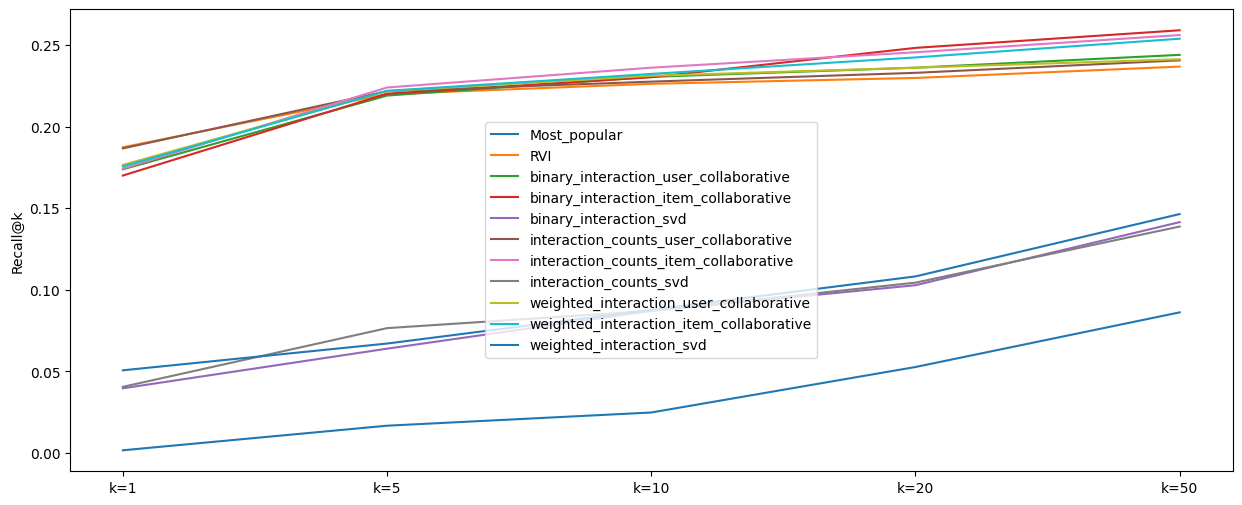

In [39]:
# Visualize results
plt.figure(figsize=(15, 6))
for model, values in results.items():
    plt.plot(values, label=model)
plt.legend()
plt.xticks(range(5), ["k=1", "k=5", "k=10", "k=20", "k=50"])
plt.ylabel("Recall@k")

In [41]:
pd.DataFrame(results).transpose()

,0,1,2,3,4
Most_popular,0.001574,0.016644,0.024741,0.052632,0.086145
RVI,0.187359,0.219973,0.226271,0.229870,0.236842
binary_interaction_user_collaborative,0.173864,0.219073,0.230544,0.236167,0.244040
binary_interaction_item_collaborative,0.170040,0.220198,0.230319,0.248313,0.259109
binary_interaction_svd,0.039586,0.063878,0.087045,0.102789,0.141475
interaction_counts_user_collaborative,0.186685,0.221772,0.227620,0.233018,0.240666
interaction_counts_item_collaborative,0.174314,0.224022,0.236167,0.245614,0.256185
interaction_counts_svd,0.040486,0.076473,0.087045,0.104363,0.138776
weighted_interaction_user_collaborative,0.176563,0.221772,0.231219,0.236167,0.241341
weighted_interaction_item_collaborative,0.175664,0.221997,0.232344,0.242465,0.253936
